# Analyzing Neighborhoods in Mumbai, India for Starting a Restaurant

## Introduction

Mumbai is the financial capital of India and is one of the most densely populated cities in the world. It lies on the west coast of India and attracts heavy tourism from all over the globe every year. Personally, I have been brought up in Mumbai and have loved the city from the bottom of my heart. It is one of the major hubs of the world and is extremely diverse with people from various ethnicities residing here. The multi-cultural nature of the city of Mumbai has brought along with it numerous cuisines from all over the world. The people of India generally love food and I personally love to try different cuisines and experience different flavors. Thus, the aim of this project is to study the neighborhoods in Mumbai to determine possible locations for opening a restaurant. This project can be useful for business owners and entrepreneurs who are looking to invest in a restaurant in Mumbai. The main objective of this project is to carefully analyze appropriate data and find recommendations for the stakeholders.

## Data Collection

The data required for this project has been collected from multiple sources. A summary of the data required for this project is given below.

### Neighborhoods Data
The data of the neighborhoods in Mumbai was scraped from https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai. The data is read into a pandas data frame using the read_html() method. The main reason for doing so is that the Wikipedia page provides a comprehensive and detailed table of the data which can easily be scraped using the read_html() method of pandas.

### Geographical Coordinates
The geographical coordinates for Mumbai data has been obtained from the GeoPy library in python. This data is relevant for plotting the map of Mumbai using the Folium library in python. The geocoder library in python has been used to obtain latitude and longitude data for various neighborhoods in Mumbai. The coordinates of all neighborhoods in Mumbai are used to check the accuracy of coordinates given on Wikipedia and replace them in our data frame if the absolute difference is more than 0.001. These coordinates are then further used for plotting using the Folium library in python.

### Venue Data
The venue data has been extracted using the Foursquare API. This data contains venue recommendations for all neighborhoods in Mumbai and is used to study the popular venues of different neighborhoods.

### Importing required libraries

In [1]:
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

     |████████████████████████████████| 102kB 7.6MB/s ta 0:00:011
     |████████████████████████████████| 102kB 6.3MB/s ta 0:00:011
All libraries imported.


### Data Retrieval

Scraping data from https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai and reading it into a dataframe.

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai')[-1]
df.rename(columns={'Area': 'Neighborhood'}, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
5,Marol,"Andheri,Western Suburbs",19.119219,72.882743
6,Sahar,"Andheri,Western Suburbs",19.098889,72.867222
7,Seven Bungalows,"Andheri,Western Suburbs",19.129052,72.817018
8,Versova,"Andheri,Western Suburbs",19.120000,72.820000
9,Mira Road,"Mira-Bhayandar,Western Suburbs",19.284167,72.871111


### Data Wrangling

Lets look at the different values for Location present in the Location column.

In [3]:
df['Location'].value_counts()

South Mumbai                       30
Andheri,Western Suburbs             8
Western Suburbs                     6
Eastern Suburbs                     4
Mira-Bhayandar,Western Suburbs      3
Ghatkopar,Eastern Suburbs           3
Powai,Eastern Suburbs               3
Kandivali West,Western Suburbs      3
Bandra,Western Suburbs              3
Kalbadevi,South Mumbai              2
Khar,Western Suburbs                2
Vasai,Western Suburbs               2
Harbour Suburbs                     2
Borivali (West),Western Suburbs     2
Mumbai                              2
Malad,Western Suburbs               2
Goregaon,Western Suburbs            2
Vile Parle,Western Suburbs          1
Tardeo,South Mumbai                 1
Dadar,South Mumbai                  1
Kamathipura,South Mumbai            1
Antop Hill,South Mumbai             1
Kurla,Eastern Suburbs               1
Govandi,Harbour Suburbs             1
Mulund,Eastern Suburbs              1
Colaba,South Mumbai                 1
Sanctacruz,W

We can see that there are many locations that appear only once or twice. This is because the main locations like "Western Suburbs" or "South Mumbai" are being further divided by the area within these locations. Lets clean the Location column to make it easier to understand.

In [4]:
df['Location'] = df['Location'].apply(lambda x: x.split(',')[-1])
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270
5,Marol,Western Suburbs,19.119219,72.882743
6,Sahar,Western Suburbs,19.098889,72.867222
7,Seven Bungalows,Western Suburbs,19.129052,72.817018
8,Versova,Western Suburbs,19.120000,72.820000
9,Mira Road,Western Suburbs,19.284167,72.871111


Now lets again look at the values in Location column.

In [5]:
df['Location'].value_counts()

South Mumbai       39
Western Suburbs    36
Eastern Suburbs    12
Harbour Suburbs     4
Mumbai              2
Name: Location, dtype: int64

Now that the data is much easier to interpret, lets display the dataframe created.

In [6]:
df

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270
5,Marol,Western Suburbs,19.119219,72.882743
6,Sahar,Western Suburbs,19.098889,72.867222
7,Seven Bungalows,Western Suburbs,19.129052,72.817018
8,Versova,Western Suburbs,19.120000,72.820000
9,Mira Road,Western Suburbs,19.284167,72.871111


Although the data we gathered contained latitude and longitude information, we can reconfirm these coordinates using Geocoder.

In [7]:
df['Latitude1'] = None
df['Longitude1'] = None

for i, neigh in enumerate(df['Neighborhood']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Mumbai, India'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude1'] = latitude
    df.loc[i, 'Longitude1'] = longitude

df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1
0,Amboli,Western Suburbs,19.129300,72.843400,19.1291,72.8464
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,19.1084,72.8623
2,D.N. Nagar,Western Suburbs,19.124085,72.831373,19.1251,72.8325
3,Four Bungalows,Western Suburbs,19.124714,72.827210,19.1263,72.8243
4,Lokhandwala,Western Suburbs,19.130815,72.829270,19.1432,72.8249
5,Marol,Western Suburbs,19.119219,72.882743,19.1191,72.8828
6,Sahar,Western Suburbs,19.098889,72.867222,19.1027,72.8626
7,Seven Bungalows,Western Suburbs,19.129052,72.817018,19.1315,72.8165
8,Versova,Western Suburbs,19.120000,72.820000,19.1377,72.8135
9,Mira Road,Western Suburbs,19.284167,72.871111,19.2657,72.8707


We can create new columns to see the difference between coordinate values obtained from wikipedia and those obtained from geocoder. We will take the absolute difference between these values and store them in our dataframe.

In [8]:
df['Latdiff'] = abs(df['Latitude'] - df['Latitude1'])
df['Longdiff'] = abs(df['Longitude'] - df['Longitude1'])
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.129300,72.843400,19.1291,72.8464,0.00024,0.00304
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,19.1084,72.8623,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.124085,72.831373,19.1251,72.8325,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.124714,72.827210,19.1263,72.8243,0.001606,0.00288
4,Lokhandwala,Western Suburbs,19.130815,72.829270,19.1432,72.8249,0.012345,0.0044
5,Marol,Western Suburbs,19.119219,72.882743,19.1191,72.8828,0.000169,6.7e-05
6,Sahar,Western Suburbs,19.098889,72.867222,19.1027,72.8626,0.00376476,0.00464166
7,Seven Bungalows,Western Suburbs,19.129052,72.817018,19.1315,72.8165,0.00240802,0.000558001
8,Versova,Western Suburbs,19.120000,72.820000,19.1377,72.8135,0.01769,0.00652
9,Mira Road,Western Suburbs,19.284167,72.871111,19.2657,72.8707,0.0184624,0.000418149


We can see that the latitude and longitudes from wikipedia and geocoder are very similar, yet there are some differences. We will replace the values with the coordinates obtained from geocoder if the absolute difference is more than 0.001.

In [9]:
df.loc[df.Latdiff>0.001, 'Latitude'] = df.loc[df.Latdiff>0.001, 'Latitude1']
df.loc[df.Longdiff>0.001, 'Longitude'] = df.loc[df.Longdiff>0.001, 'Longitude1']
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.8464,19.1291,72.8464,0.00024,0.00304
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,19.1251,72.8325,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.1263,72.8243,19.1263,72.8243,0.001606,0.00288
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249,0.012345,0.0044
5,Marol,Western Suburbs,19.1192,72.8827,19.1191,72.8828,0.000169,6.7e-05
6,Sahar,Western Suburbs,19.1027,72.8626,19.1027,72.8626,0.00376476,0.00464166
7,Seven Bungalows,Western Suburbs,19.1315,72.817,19.1315,72.8165,0.00240802,0.000558001
8,Versova,Western Suburbs,19.1377,72.8135,19.1377,72.8135,0.01769,0.00652
9,Mira Road,Western Suburbs,19.2657,72.8711,19.2657,72.8707,0.0184624,0.000418149


In order to confirm if values have actually been replaced we can use the where method. Values with NaN means those values have not been replaced.

In [10]:
df.where(df['Latitude']==df['Latitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623,0.003028,0.001497
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Four Bungalows,Western Suburbs,19.1263,72.8243,19.1263,72.8243,0.001606,0.00288
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249,0.012345,0.0044
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Sahar,Western Suburbs,19.1027,72.8626,19.1027,72.8626,0.00376476,0.00464166
7,Seven Bungalows,Western Suburbs,19.1315,72.817,19.1315,72.8165,0.00240802,0.000558001
8,Versova,Western Suburbs,19.1377,72.8135,19.1377,72.8135,0.01769,0.00652
9,Mira Road,Western Suburbs,19.2657,72.8711,19.2657,72.8707,0.0184624,0.000418149


We can do the same for the Longitude column.

In [11]:
df.where(df['Longitude']==df['Longitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Amboli,Western Suburbs,19.1293,72.8464,19.1291,72.8464,0.00024,0.00304
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,19.1084,72.8623,0.003028,0.001497
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,19.1251,72.8325,0.000965,0.001107
3,Four Bungalows,Western Suburbs,19.1263,72.8243,19.1263,72.8243,0.001606,0.00288
4,Lokhandwala,Western Suburbs,19.1432,72.8249,19.1432,72.8249,0.012345,0.0044
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Sahar,Western Suburbs,19.1027,72.8626,19.1027,72.8626,0.00376476,0.00464166
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Versova,Western Suburbs,19.1377,72.8135,19.1377,72.8135,0.01769,0.00652
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that we have the data, we can drop the columns that are no longer useful.

In [12]:
df.drop(['Latitude1', 'Longitude1', 'Latdiff', 'Longdiff'], axis=1, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.1293,72.8464
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623
2,D.N. Nagar,Western Suburbs,19.1241,72.8325
3,Four Bungalows,Western Suburbs,19.1263,72.8243
4,Lokhandwala,Western Suburbs,19.1432,72.8249
5,Marol,Western Suburbs,19.1192,72.8827
6,Sahar,Western Suburbs,19.1027,72.8626
7,Seven Bungalows,Western Suburbs,19.1315,72.817
8,Versova,Western Suburbs,19.1377,72.8135
9,Mira Road,Western Suburbs,19.2657,72.8711


### Data Visualization

To understand our data better, we can see how many neighborhoods are in each location.

In [13]:
neighborhoods_mumbai = df.groupby('Location')['Neighborhood'].nunique()
neighborhoods_mumbai

Location
Eastern Suburbs    12
Harbour Suburbs     4
Mumbai              2
South Mumbai       39
Western Suburbs    36
Name: Neighborhood, dtype: int64

We can now plot this data.

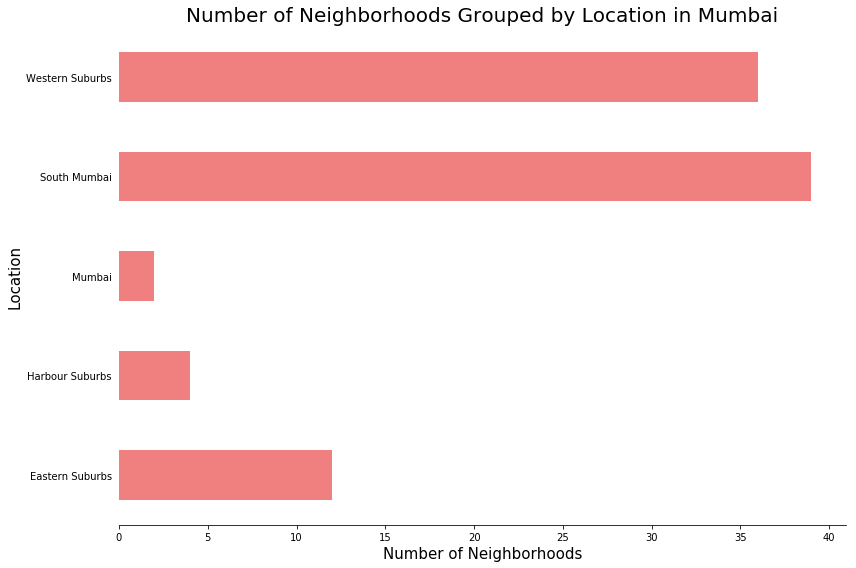

In [14]:
fig = plt.figure(figsize=(12,8))

ax = neighborhoods_mumbai.plot(kind='barh', color='lightcoral')
ax.set_title('Number of Neighborhoods Grouped by Location in Mumbai', fontsize=20)
ax.set_xlabel('Number of Neighborhoods', fontsize=15)
ax.set_ylabel('Location', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(which='major', left=False)

fig.tight_layout()

Clearly we can see that South Mumbai and Western Suburbs have the most number of neighborhoods. Notice how we see one of the locations as Mumbai itself? This is because the neighborhoods contained in this location are located at the outskirts of Mumbai and thus have been grouped as just Mumbai.

Now lets visualize the neighborhoods on a map using Folium. First we will obtain the geographical coordinates of Mumbai using GeoPy.

In [15]:
address = 'Mumbai, IN'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Mumbai are 19.0759899, 72.8773928.


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  from ipykernel import kernelapp as app


Now we can plot the map.

In [16]:
map_mum = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(df['Latitude'], df['Longitude'], df['Location'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

### Using Foursquare API

Now we can start working with the Foursquare API to obtain venue recommendations.

Lets create the Foursquare credentials first.

In [17]:
# The code was removed by Watson Studio for sharing.

Lets start by exploring just the first neighborhood in our dataframe using Foursquare API.

In [18]:
neighborhood_name = df.loc[0, 'Neighborhood']
neighborhood_lat = df.loc[0, 'Latitude']
neighborhood_long = df.loc[0, 'Longitude']

print("The neighborhood is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The neighborhood is Amboli and it's geographical coordinates are 19.1293 latitude and 72.84644000000003 longitude


We will now extract the top 200 venues near Amboli with a radius of 1000m or 1km. In order to do this, we will start by creating a url.

In [19]:
LIMIT = 200
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

We can now use the GET method to get our results.

In [20]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f29284ea77aef7f1dde8fb4'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Jogeshwari West',
  'headerFullLocation': 'Jogeshwari West, Mumbai',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 30,
  'suggestedBounds': {'ne': {'lat': 19.13830000900001,
    'lng': 72.85594823590122},
   'sw': {'lat': 19.120299990999992, 'lng': 72.83693176409884}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d10d39b7177b1f7d2c75322',
       'name': 'Cafe Arfa',
       'location': {'address': 'S V Road',
        'crossStreet': 'Andheri West',
        'lat': 19.12893009094341,
        'lng': 72.84714004510111,
        'labeledLatLngs': [{'label'

We will now create a function get_category_type to extract the categories of venues.

In [21]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we can clean the JSON obtained using the GET method and store our results in a dataframe.

In [22]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Cafe Arfa,Indian Restaurant,19.128930,72.847140
1,"5 Spice , Bandra",Chinese Restaurant,19.130421,72.847206
2,Shawarma Factory,Falafel Restaurant,19.124591,72.840398
3,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant,19.137714,72.845909
4,Narayan Sandwich,Sandwich Place,19.121398,72.850270


We can check how many venues were returned by Foursquare.

In [23]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

30 venues were returned for Amboli by Foursquare


### Generalizing Foursquare API

Now that we have seen how the API call works and how we can clean our data to get relevant information, we can generalize this procedure to get nearby venues for all neighborhoods by creating the function getNearbyVenues.

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We can apply the function created to get nearby venues for all neighborhoods in Mumbai. We will get 200 nearby venues within a 1km radius, same as before.

In [26]:
mum_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius)

Amboli
Chakala, Andheri
D.N. Nagar
Four Bungalows
Lokhandwala
Marol
Sahar
Seven Bungalows
Versova
Mira Road
Bhayandar
Uttan
Bandstand Promenade
Kherwadi
Pali Hill
I.C. Colony
Gorai
Dahisa
Aarey Milk Colony
Bangur Nagar
Jogeshwari West
Juhu
Charkop
Poisar
Mahavir Nagar
Thakur village
Pali Naka
Khar Danda
Dindoshi
Sunder Nagar
Kalina
Naigaon
Nalasopara
Virar
Irla
Vile Parle
Bhandup
Amrut Nagar
Asalfa
Pant Nagar
Kanjurmarg
Nehru Nagar
Nahur
Chandivali
Hiranandani Gardens
Indian Institute of Technology Bombay campus
Vidyavihar
Vikhroli
Chembur
Deonar
Mankhurd
Mahul
Agripada
Altamount Road
Bhuleshwar
Breach Candy
Carmichael Road
Cavel
Churchgate
Cotton Green
Cuffe Parade
Cumbala Hill
Currey Road
Dhobitalao
Dongri
Kala Ghoda
Kemps Corner
Lower Parel
Mahalaxmi
Mahim
Malabar Hill
Marine Drive
Marine Lines
Mumbai Central
Nariman Point
Prabhadevi
Sion
Walkeshwar
Worli
C.G.S. colony
Dagdi Chawl
Navy Nagar
Hindu colony
Ballard Estate
Chira Bazaar
Fanas Wadi
Chor Bazaar
Matunga
Parel
Gowalia Tank
D

Lets see what our dataframe looks like.

In [27]:
print(mum_venues.shape)
mum_venues.head(10)

(3766, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,19.1293,72.84644,Cafe Arfa,19.128930,72.847140,Indian Restaurant
1,Amboli,19.1293,72.84644,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
2,Amboli,19.1293,72.84644,Shawarma Factory,19.124591,72.840398,Falafel Restaurant
3,Amboli,19.1293,72.84644,Jaffer Bhai's Delhi Darbar,19.137714,72.845909,Mughlai Restaurant
4,Amboli,19.1293,72.84644,Narayan Sandwich,19.121398,72.850270,Sandwich Place
5,Amboli,19.1293,72.84644,Persia Darbar,19.136952,72.846822,Indian Restaurant
6,Amboli,19.1293,72.84644,Domino's Pizza,19.131000,72.848000,Pizza Place
7,Amboli,19.1293,72.84644,Garden Court,19.127188,72.837478,Indian Restaurant
8,Amboli,19.1293,72.84644,Subway,19.127860,72.844461,Sandwich Place
9,Amboli,19.1293,72.84644,Sarvodaya Veg. Restaurant,19.123760,72.850893,Indian Restaurant


Lets see how many venues were returned for each neighborhood.

In [28]:
mum_venues.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aarey Milk Colony,47,47,47,47,47,47
1,Agripada,29,29,29,29,29,29
2,Altamount Road,71,71,71,71,71,71
3,Amboli,30,30,30,30,30,30
4,Amrut Nagar,15,15,15,15,15,15
5,Asalfa,10,10,10,10,10,10
6,Ballard Estate,63,63,63,63,63,63
7,Bandstand Promenade,35,35,35,35,35,35
8,Bangur Nagar,40,40,40,40,40,40
9,Bhandup,5,5,5,5,5,5


We can now check how many unique categories are there in our data.

In [29]:
print("There are {} unique categories".format(mum_venues['Venue Category'].nunique()))

There are 221 unique categories


### Analyzing each neighborhood

We can start analyzing each neighborhood by One-hot Encoding to see which categories belong in which neighborhoods.

In [30]:
mum_onehot = pd.get_dummies(mum_venues[['Venue Category']], prefix="", prefix_sep="")
mum_onehot.head()

,ATM,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Adding Neighborhood column to the one-hot encoded dataframe.

In [31]:
mum_onehot['Neighborhood'] = mum_venues['Neighborhood']
mum_onehot.head()

,ATM,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Moving the Neighborhood column to the first column.

In [32]:
temp = list(mum_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
mum_onehot = mum_onehot[fixed_columns]

mum_onehot.head()

,Neighborhood,ATM,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can groupby neighborhood and take the mean for all categories.

In [33]:
mum_grouped = mum_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(mum_grouped.shape)
mum_grouped.head(10)

(93, 221)


,Neighborhood,ATM,Accessories Store,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,...,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Amboli,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.000000,0.0,0.0
1,"Chakala, Andheri",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.047619,0.0,0.0,0.000,0.000000,0.0,0.0
2,D.N. Nagar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.043478,0.0,0.0,0.000,0.021739,0.0,0.0
3,Four Bungalows,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.030303,0.0,0.0,0.000,0.015152,0.0,0.0
4,Lokhandwala,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.010753,0.0,0.0,0.000,0.010753,0.0,0.0
5,Marol,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.000000,0.0,0.0
6,Sahar,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.000000,0.0,0.0
7,Seven Bungalows,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.014925,...,0.0,0.0,0.0,0.029851,0.0,0.0,0.000,0.000000,0.0,0.0
8,Versova,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.025000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.025,0.000000,0.0,0.0
9,Mira Road,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.066667,0.0,0.0


In order to further understand the data, we can display the top 5 venues of all neighborhoods.

In [34]:
num_top_venues = 5

for hood in mum_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mum_grouped[mum_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amboli----
               venue  freq
0  Indian Restaurant  0.13
1        Coffee Shop  0.10
2        Pizza Place  0.07
3   Asian Restaurant  0.07
4     Sandwich Place  0.07


----Chakala, Andheri----
               venue  freq
0              Hotel  0.17
1  Indian Restaurant  0.14
2               Café  0.10
3         Restaurant  0.05
4          Hotel Bar  0.05


----D.N. Nagar----
                  venue  freq
0                   Bar  0.11
1                   Pub  0.09
2     Indian Restaurant  0.09
3           Pizza Place  0.07
4  Gym / Fitness Center  0.07


----Four Bungalows----
                venue  freq
0                 Pub  0.08
1                Café  0.06
2   Indian Restaurant  0.06
3              Lounge  0.05
4  Chinese Restaurant  0.05


----Lokhandwala----
                venue  freq
0   Indian Restaurant  0.13
1  Chinese Restaurant  0.06
2                Café  0.05
3                 Pub  0.04
4              Bakery  0.04


----Marol----
                  venue  freq
0   

Lets now create a dataframe with the top 10 common venues for each neighborhood.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_grouped['Neighborhood']

for ind in np.arange(mum_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Indian Restaurant,Coffee Shop,Bakery,Bar,Asian Restaurant,Pizza Place,Sandwich Place,Bowling Alley,Bus Station,Bike Rental / Bike Share
1,"Chakala, Andheri",Hotel,Indian Restaurant,Café,Fast Food Restaurant,Pizza Place,Asian Restaurant,Hotel Bar,Vegetarian / Vegan Restaurant,Restaurant,Gym
2,D.N. Nagar,Bar,Indian Restaurant,Pub,Gym / Fitness Center,Pizza Place,Lounge,Coffee Shop,Vegetarian / Vegan Restaurant,Snack Place,Gym
3,Four Bungalows,Pub,Café,Indian Restaurant,Gym / Fitness Center,Chinese Restaurant,Bar,Seafood Restaurant,Lounge,Vegetarian / Vegan Restaurant,Coffee Shop
4,Lokhandwala,Indian Restaurant,Chinese Restaurant,Café,Pub,Bakery,Bar,Italian Restaurant,Gym / Fitness Center,Coffee Shop,Asian Restaurant
5,Marol,Indian Restaurant,Hotel,Diner,Bakery,Dance Studio,Ice Cream Shop,Chinese Restaurant,Fast Food Restaurant,Restaurant,Lounge
6,Sahar,Hotel,Café,Indian Restaurant,Lounge,Gym,Asian Restaurant,Pizza Place,Seafood Restaurant,Restaurant,Falafel Restaurant
7,Seven Bungalows,Café,Pub,Seafood Restaurant,Chinese Restaurant,Pizza Place,Coffee Shop,Bar,Ice Cream Shop,Asian Restaurant,Bistro
8,Versova,Café,Ice Cream Shop,Beach,Pizza Place,Coffee Shop,Chinese Restaurant,Salon / Barbershop,Frozen Yogurt Shop,Bistro,Sandwich Place
9,Mira Road,Indian Restaurant,Convenience Store,Coffee Shop,Mexican Restaurant,Fast Food Restaurant,Food Truck,Motorcycle Shop,Movie Theater,Basketball Court,Bar


### Clustering neighborhoods

Now we can use KMeans clustering method to cluster the neighborhoods.

First we need to determine how many clusters to use. This will be done using the Silhouette Score.

We will define a function to plot the Silhouette Score that will be calculated using different number of clusters. 

In [37]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [38]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = mum_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

We can now display the scores for different number of clusters and plot the data as well.

[0.09249638480354469, 0.05769793262530753, 0.07827283426763512, 0.09917677954202117, 0.08580272612412242, 0.08598687206817208, 0.09211666612115685, 0.05165397104393539, 0.06314203182571597, 0.08526705717813107, 0.05876252041813831, 0.060133085496564084, 0.07398191498162245, 0.09066730835842506]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


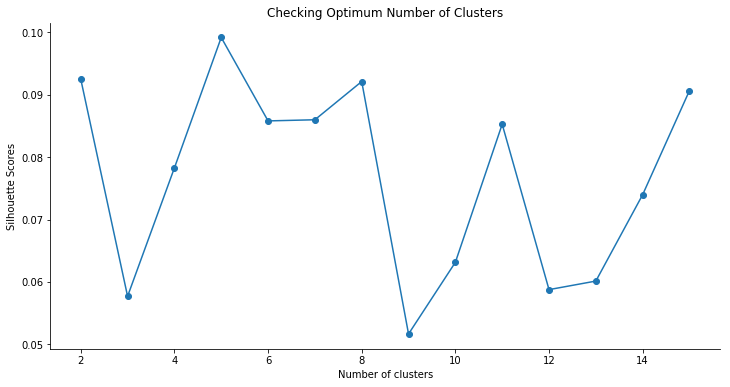

In [39]:
print(scores)
print(kval)
plot(kval, scores)

We can see that the silhouette scores are not very high even as we increase the number of clusters. This means that the inter-cluster distance between different clusters is not very high over the range of k-values. However, we will try to cluster our data as best as we can. For this, we will use 5 clusters for our clustering model since it provides the highest silhouette score as seen above.

In [40]:
k = 5

mum_clustering = mum_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(mum_clustering) #Can choose any random_state

kmeans.labels_

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 2, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 3, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 4], dtype=int32)

Now we can create a new dataframe that includes cluster labels and the top 10 venues.

In [41]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
mum_merged = df
mum_merged = mum_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Lets view the newly created dataframe.

In [42]:
print(mum_merged.shape)
mum_merged

(93, 15)


,Neighborhood,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,19.1293,72.8464,1,Indian Restaurant,Coffee Shop,Bakery,Bar,Asian Restaurant,Pizza Place,Sandwich Place,Bowling Alley,Bus Station,Bike Rental / Bike Share
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,1,Hotel,Indian Restaurant,Café,Fast Food Restaurant,Pizza Place,Asian Restaurant,Hotel Bar,Vegetarian / Vegan Restaurant,Restaurant,Gym
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,0,Bar,Indian Restaurant,Pub,Gym / Fitness Center,Pizza Place,Lounge,Coffee Shop,Vegetarian / Vegan Restaurant,Snack Place,Gym
3,Four Bungalows,Western Suburbs,19.1263,72.8243,0,Pub,Café,Indian Restaurant,Gym / Fitness Center,Chinese Restaurant,Bar,Seafood Restaurant,Lounge,Vegetarian / Vegan Restaurant,Coffee Shop
4,Lokhandwala,Western Suburbs,19.1432,72.8249,0,Indian Restaurant,Chinese Restaurant,Café,Pub,Bakery,Bar,Italian Restaurant,Gym / Fitness Center,Coffee Shop,Asian Restaurant
5,Marol,Western Suburbs,19.1192,72.8827,1,Indian Restaurant,Hotel,Diner,Bakery,Dance Studio,Ice Cream Shop,Chinese Restaurant,Fast Food Restaurant,Restaurant,Lounge
6,Sahar,Western Suburbs,19.1027,72.8626,0,Hotel,Café,Indian Restaurant,Lounge,Gym,Asian Restaurant,Pizza Place,Seafood Restaurant,Restaurant,Falafel Restaurant
7,Seven Bungalows,Western Suburbs,19.1315,72.817,0,Café,Pub,Seafood Restaurant,Chinese Restaurant,Pizza Place,Coffee Shop,Bar,Ice Cream Shop,Asian Restaurant,Bistro
8,Versova,Western Suburbs,19.1377,72.8135,0,Café,Ice Cream Shop,Beach,Pizza Place,Coffee Shop,Chinese Restaurant,Salon / Barbershop,Frozen Yogurt Shop,Bistro,Sandwich Place
9,Mira Road,Western Suburbs,19.2657,72.8711,1,Indian Restaurant,Convenience Store,Coffee Shop,Mexican Restaurant,Fast Food Restaurant,Food Truck,Motorcycle Shop,Movie Theater,Basketball Court,Bar


We can visualize the clustering by creating a map.

In [51]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(mum_merged['Latitude'], mum_merged['Longitude'], mum_merged['Neighborhood'], mum_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can now view the neighborhoods in each cluster and their top 10 most common venues.

### Cluster 1

In [44]:
mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,D.N. Nagar,Western Suburbs,Bar,Indian Restaurant,Pub,Gym / Fitness Center,Pizza Place,Lounge,Coffee Shop,Vegetarian / Vegan Restaurant,Snack Place,Gym
3,Four Bungalows,Western Suburbs,Pub,Café,Indian Restaurant,Gym / Fitness Center,Chinese Restaurant,Bar,Seafood Restaurant,Lounge,Vegetarian / Vegan Restaurant,Coffee Shop
4,Lokhandwala,Western Suburbs,Indian Restaurant,Chinese Restaurant,Café,Pub,Bakery,Bar,Italian Restaurant,Gym / Fitness Center,Coffee Shop,Asian Restaurant
6,Sahar,Western Suburbs,Hotel,Café,Indian Restaurant,Lounge,Gym,Asian Restaurant,Pizza Place,Seafood Restaurant,Restaurant,Falafel Restaurant
7,Seven Bungalows,Western Suburbs,Café,Pub,Seafood Restaurant,Chinese Restaurant,Pizza Place,Coffee Shop,Bar,Ice Cream Shop,Asian Restaurant,Bistro
8,Versova,Western Suburbs,Café,Ice Cream Shop,Beach,Pizza Place,Coffee Shop,Chinese Restaurant,Salon / Barbershop,Frozen Yogurt Shop,Bistro,Sandwich Place
10,Bhayandar,Western Suburbs,Bakery,Pizza Place,Lake,Electronics Store,Ice Cream Shop,Diner,Indian Restaurant,Food Truck,Restaurant,Factory
11,Uttan,Western Suburbs,ATM,Café,Food Truck,Bakery,River,Restaurant,Metro Station,Design Studio,Fish Market,Fish & Chips Shop
12,Bandstand Promenade,Western Suburbs,Coffee Shop,Café,Tea Room,Scenic Lookout,Deli / Bodega,Performing Arts Venue,Food Truck,Indian Restaurant,Fast Food Restaurant,Lounge
13,Kherwadi,Western Suburbs,Café,Indian Restaurant,Hookah Bar,Restaurant,Italian Restaurant,Pizza Place,Seafood Restaurant,Bar,Chinese Restaurant,South American Restaurant


### Cluster 2

In [45]:
mum_merged.loc[mum_merged['Cluster Labels'] == 1, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,Indian Restaurant,Coffee Shop,Bakery,Bar,Asian Restaurant,Pizza Place,Sandwich Place,Bowling Alley,Bus Station,Bike Rental / Bike Share
1,"Chakala, Andheri",Western Suburbs,Hotel,Indian Restaurant,Café,Fast Food Restaurant,Pizza Place,Asian Restaurant,Hotel Bar,Vegetarian / Vegan Restaurant,Restaurant,Gym
5,Marol,Western Suburbs,Indian Restaurant,Hotel,Diner,Bakery,Dance Studio,Ice Cream Shop,Chinese Restaurant,Fast Food Restaurant,Restaurant,Lounge
9,Mira Road,Western Suburbs,Indian Restaurant,Convenience Store,Coffee Shop,Mexican Restaurant,Fast Food Restaurant,Food Truck,Motorcycle Shop,Movie Theater,Basketball Court,Bar
15,I.C. Colony,Western Suburbs,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Bar,Dessert Shop,Pizza Place,Juice Bar,Basketball Court,Soccer Field
18,Aarey Milk Colony,Western Suburbs,Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Shopping Mall,Breakfast Spot,Snack Place,Bookstore,Coffee Shop,Donut Shop,Bar
19,Bangur Nagar,Western Suburbs,Coffee Shop,Indian Restaurant,Clothing Store,Multiplex,Fast Food Restaurant,Pizza Place,Electronics Store,Smoke Shop,Middle Eastern Restaurant,Pub
20,Jogeshwari West,Western Suburbs,Indian Restaurant,Men's Store,Asian Restaurant,Fried Chicken Joint,Mughlai Restaurant,Café,Chinese Restaurant,Smoke Shop,Flea Market,Ice Cream Shop
21,Juhu,Western Suburbs,Indian Restaurant,Coffee Shop,Flower Shop,Shopping Mall,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Movie Theater,Café,Lounge,Breakfast Spot
23,Poisar,Western Suburbs,Indian Restaurant,Train Station,Dessert Shop,Sandwich Place,Food,Electronics Store,Fast Food Restaurant,Men's Store,Mexican Restaurant,Snack Place


### Cluster 3

In [46]:
mum_merged.loc[mum_merged['Cluster Labels'] == 2, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Bhandup,Eastern Suburbs,Train Station,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Zoo,Donut Shop,Flea Market,Fish Market,Fish & Chips Shop,Field
40,Kanjurmarg,Eastern Suburbs,Train Station,Gift Shop,Gym,Multiplex,Asian Restaurant,Chinese Restaurant,Cupcake Shop,Hotel,Field,Fast Food Restaurant
90,Dava Bazaar,South Mumbai,Train Station,Indian Restaurant,Cupcake Shop,Hotel,Fish Market,Café,Fast Food Restaurant,Coffee Shop,Asian Restaurant,Smoke Shop


### Cluster 4

In [47]:
mum_merged.loc[mum_merged['Cluster Labels'] == 3, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Mankhurd,Harbour Suburbs,Train Station,Coffee Shop,Sports Bar,Bus Station,Zoo,Electronics Store,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant


### Cluster 5

In [48]:
mum_merged.loc[mum_merged['Cluster Labels'] == 4, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
92,Thane,Mumbai,Pizza Place,Performing Arts Venue,Fast Food Restaurant,Dive Bar,Fish Market,Fish & Chips Shop,Field,Farmers Market,Farm,Falafel Restaurant


## Results and Discussion

By analyzing the five clusters obtained we can see that some of the clusters are more suited for restaurants and hotels, whereas, other clusters are less suited. Neighborhoods in clusters 3, 4, and 5 contain a small percentage of restaurants, hotels, cafe and pubs in their top 10 common venues. These clusters contain a higher degree of other venues like train station, bus station, fish market, gym, performing arts venue and smoke shop, to name a few. Thus, they are not well suited for opening a new restaurant. On the other hand, neighborhoods in clusters 1 and 2 contain a much higher degree of restaurants, hotels, multiplex, cafes, bars and other food joints. Thus, the neighborhoods in these clusters would be well suited for opening a new restaurant.

Comparing clusters 1 and 2, neighborhoods in cluster 1 seem to be more suited for starting a restaurant since they contains a larger percentage of food joints in the top 10 most common venues than cluster 2. The neighborhoods in cluster 1 contain a variety of food joints like restaurants, tea rooms, bakery, cafe, steakhouse and pubs and also contain very diverse cuisines like Japanese, Indian, Chinese, Italian and seafood restaurants. Most neighborhoods in cluster 2 seem to have Indian Restaurant as their top most common venue; however, on careful analysis we can see that neighborhoods in cluster 2 also contain other venues like soccer field, flea market, smoke shop, gym, train station, dance studio, music store, cosmetics shop and so on. Thus, it is recommended that the new restaurant can be opened in the neighborhoods belonging to cluster 1. This neighborhood can be further plotted on a map as shown below.

In [49]:
new_restaurant_neighborhoods = mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0, 1, 2, 3] + list(range(5, mum_merged.shape[1]))]]
new_restaurant_neighborhoods.head()

,Neighborhood,Location,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,D.N. Nagar,Western Suburbs,19.1241,72.8325,Bar,Indian Restaurant,Pub,Gym / Fitness Center,Pizza Place,Lounge,Coffee Shop,Vegetarian / Vegan Restaurant,Snack Place,Gym
3,Four Bungalows,Western Suburbs,19.1263,72.8243,Pub,Café,Indian Restaurant,Gym / Fitness Center,Chinese Restaurant,Bar,Seafood Restaurant,Lounge,Vegetarian / Vegan Restaurant,Coffee Shop
4,Lokhandwala,Western Suburbs,19.1432,72.8249,Indian Restaurant,Chinese Restaurant,Café,Pub,Bakery,Bar,Italian Restaurant,Gym / Fitness Center,Coffee Shop,Asian Restaurant
6,Sahar,Western Suburbs,19.1027,72.8626,Hotel,Café,Indian Restaurant,Lounge,Gym,Asian Restaurant,Pizza Place,Seafood Restaurant,Restaurant,Falafel Restaurant
7,Seven Bungalows,Western Suburbs,19.1315,72.817,Café,Pub,Seafood Restaurant,Chinese Restaurant,Pizza Place,Coffee Shop,Bar,Ice Cream Shop,Asian Restaurant,Bistro


In [50]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(new_restaurant_neighborhoods['Latitude'], new_restaurant_neighborhoods['Longitude'],
                                            new_restaurant_neighborhoods['Location'], new_restaurant_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations

## Conclusion

We have successfully analyzed the neighborhoods in Mumbai, India for determining which would be the best neighborhoods for opening a new restaurant. Based on our analysis, neighborhoods in cluster 1 are recommended as locations for the new restaurant. This has also been plotted in the map above. The stakeholders and investors can further tune this by considering various other factors like transport, legal requirements, and costs associated. These were out of the scope for this project and thus were not considered.

### Note: If the maps are not visible, kindly check out my Final Report for this project for viewing the maps.



# Thank You!